In [2]:
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#tensorflow for ResNet50
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
#sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, confusion_matrix
%matplotlib inline

In [2]:
# import zipfile
# with zipfile.ZipFile('NWPU_lowy400.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

In [3]:
#!rm -r NWPU_medy400.zip

#Feature Engineering; resizing the images. Based on experimental verification
#with 256 x 256 pixels and full dataset, 
#training the model would take according to Jupyter 100+ hours which is not feasible this time
from PIL import Image
import os

def resize_images(input_directory, output_directory, target_size=(64, 64)):
    os.makedirs(output_directory)
    for foldername in os.listdir(input_directory):
        folder_path = os.path.join(input_directory, foldername)
        output_folder_path = os.path.join(output_directory, foldername)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)  
            image = Image.open(image_path)
            image_resized = image.resize(target_size, Image.ANTIALIAS)
            output_image_path = os.path.join(output_folder_path, filename)
            image_resized.save(output_image_path)

input_dir = "NWPU-RESISC45"
output_dir = "NWPU_medy"
resize_images(input_dir, output_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'NWPU-RESISC45'

In [3]:
img_height = 64 
img_width = 64
dataset_u = r'NWPU_lowy400'
batch_size = 32
validation_split=0.2
rescale=1.0/255

In [4]:
#source directly from github, initially from Coursera: https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%202/ResNets/Residual_Networks_v2a.ipynb
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_u, image_size=(img_height, img_width), batch_size=batch_size)


Found 18000 files belonging to 45 classes.


2023-10-11 10:48:30.618526: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#source directly from github, initially from Coursera: https://github.com/iamtekson/DL-for-LULC-prediction/blob/master/lulc_classification_euroSAT.ipynb
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_u,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 14400 images belonging to 45 classes.


In [6]:
#source directly from github, initially from Coursera: https://github.com/iamtekson/DL-for-LULC-prediction/blob/master/lulc_classification_euroSAT.ipynb
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_u,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')
#here test_dataset actually refers to validation data that is used to choose the best model 

Found 3600 images belonging to 45 classes.


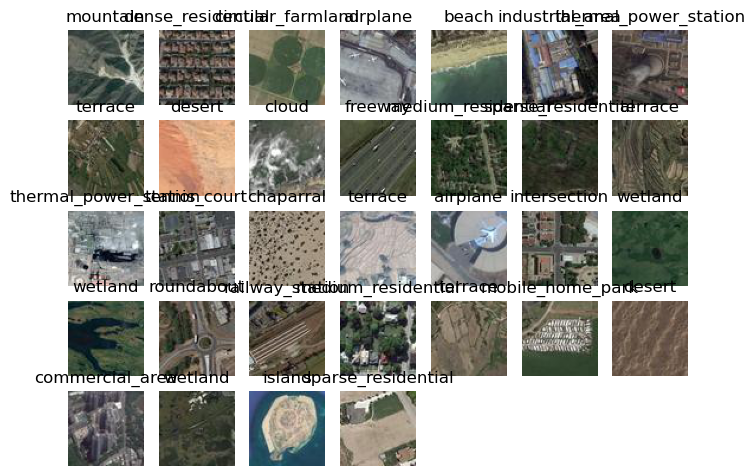

In [7]:
#source directly github (with modification in range and size), initially from Coursera: https://github.com/iamtekson/DL-for-LULC-prediction/blob/master/lulc_classification_euroSAT.ipynb
class_names = dataset.class_names
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(7, 7, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
#function taken directly from github, initially from Coursera: https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%202/ResNets/Residual_Networks_v2a.ipynb
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [9]:
#function taken directly from github, initially from Coursera: https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%202/ResNets/Residual_Networks_v2a.ipynb
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
#function taken directly from github, initially from Coursera: https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%202/ResNets/Residual_Networks_v2a.ipynb
def ResNet50(input_shape = (64, 64, 3), classes = 45):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    #X = tf.keras.layers.GlobalAveragePooling2D()(X) #this was tested in our model for Aalto ML

    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [11]:
model = ResNet50(input_shape=(64,64,3), classes=45)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=16, batch_size=32)

Epoch 1/16
450/450 [==============================] - 1330s 3s/step - loss: 3.6408 - accuracy: 0.1465 - val_loss: 2.8226 - val_accuracy: 0.2094
Epoch 2/16
450/450 [==============================] - 1252s 3s/step - loss: 2.7057 - accuracy: 0.2689 - val_loss: 2.6093 - val_accuracy: 0.2961
Epoch 3/16
450/450 [==============================] - 1253s 3s/step - loss: 2.3963 - accuracy: 0.3464 - val_loss: 2.4353 - val_accuracy: 0.3494
Epoch 4/16
450/450 [==============================] - 1253s 3s/step - loss: 2.2477 - accuracy: 0.3939 - val_loss: 2.6038 - val_accuracy: 0.3194
Epoch 5/16
450/450 [==============================] - 1247s 3s/step - loss: 2.0780 - accuracy: 0.4420 - val_loss: 2.0075 - val_accuracy: 0.4494
Epoch 6/16
450/450 [==============================] - 1281s 3s/step - loss: 1.9836 - accuracy: 0.4651 - val_loss: 2.3758 - val_accuracy: 0.3633
Epoch 7/16
450/450 [==============================] - 1334s 3s/step - loss: 1.7868 - accuracy: 0.5129 - val_loss: 2.1463 - val_accuracy:

In [14]:
model.save('CNN_16_epoch')

2023-10-10 15:05:13.207786: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CNN_16_epoch/assets


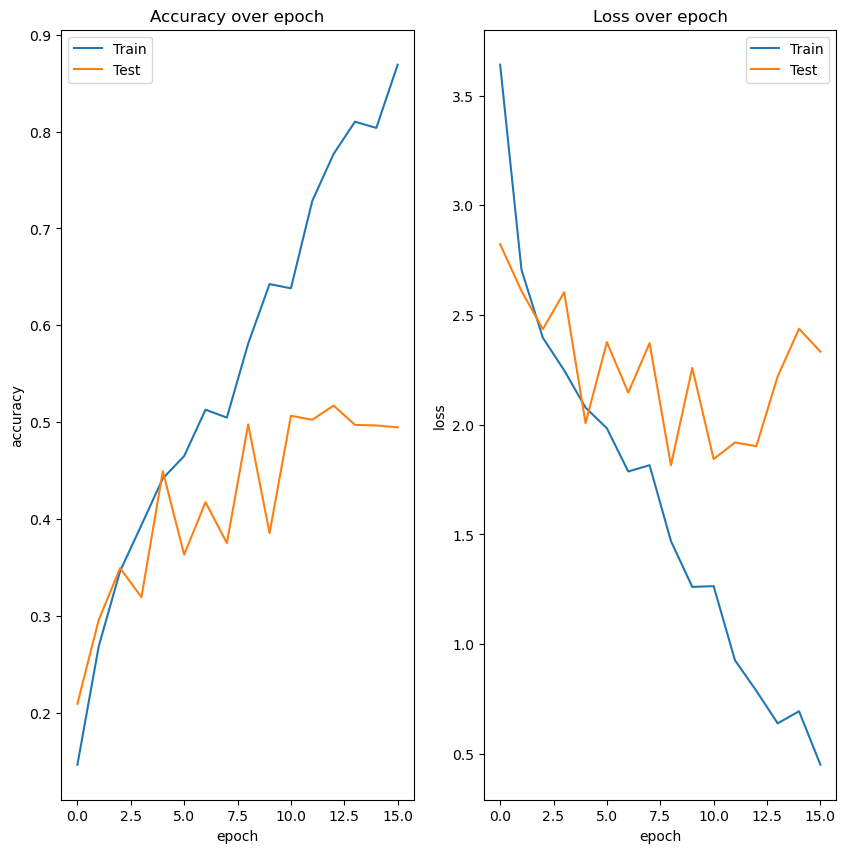

In [15]:
#source directly from github, initially from Coursera: https://github.com/iamtekson/DL-for-LULC-prediction/blob/master/lulc_classification_euroSAT.ipynb
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [16]:
y_pred = []#predicted values
y_true = []#true values, labeled in the dataset

for i, (image_batch, label_batch) in enumerate(test_dataset):
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis =  1))
    if i==112:
        break
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [20]:
# print(len(y_pred))
# print(y_pred)
#from sklearn.metrics import classification_report
#print("\nClassification Report:\n", classification_report(y_true, y_pred))
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[50,  3,  0, ...,  0,  4,  0],
       [ 0, 26,  1, ...,  0,  3,  0],
       [ 1,  3, 37, ...,  2,  0,  0],
       ...,
       [ 1,  5,  1, ..., 32,  6,  0],
       [ 0,  3,  0, ...,  0, 37,  0],
       [ 0,  0,  0, ...,  3,  1, 42]])

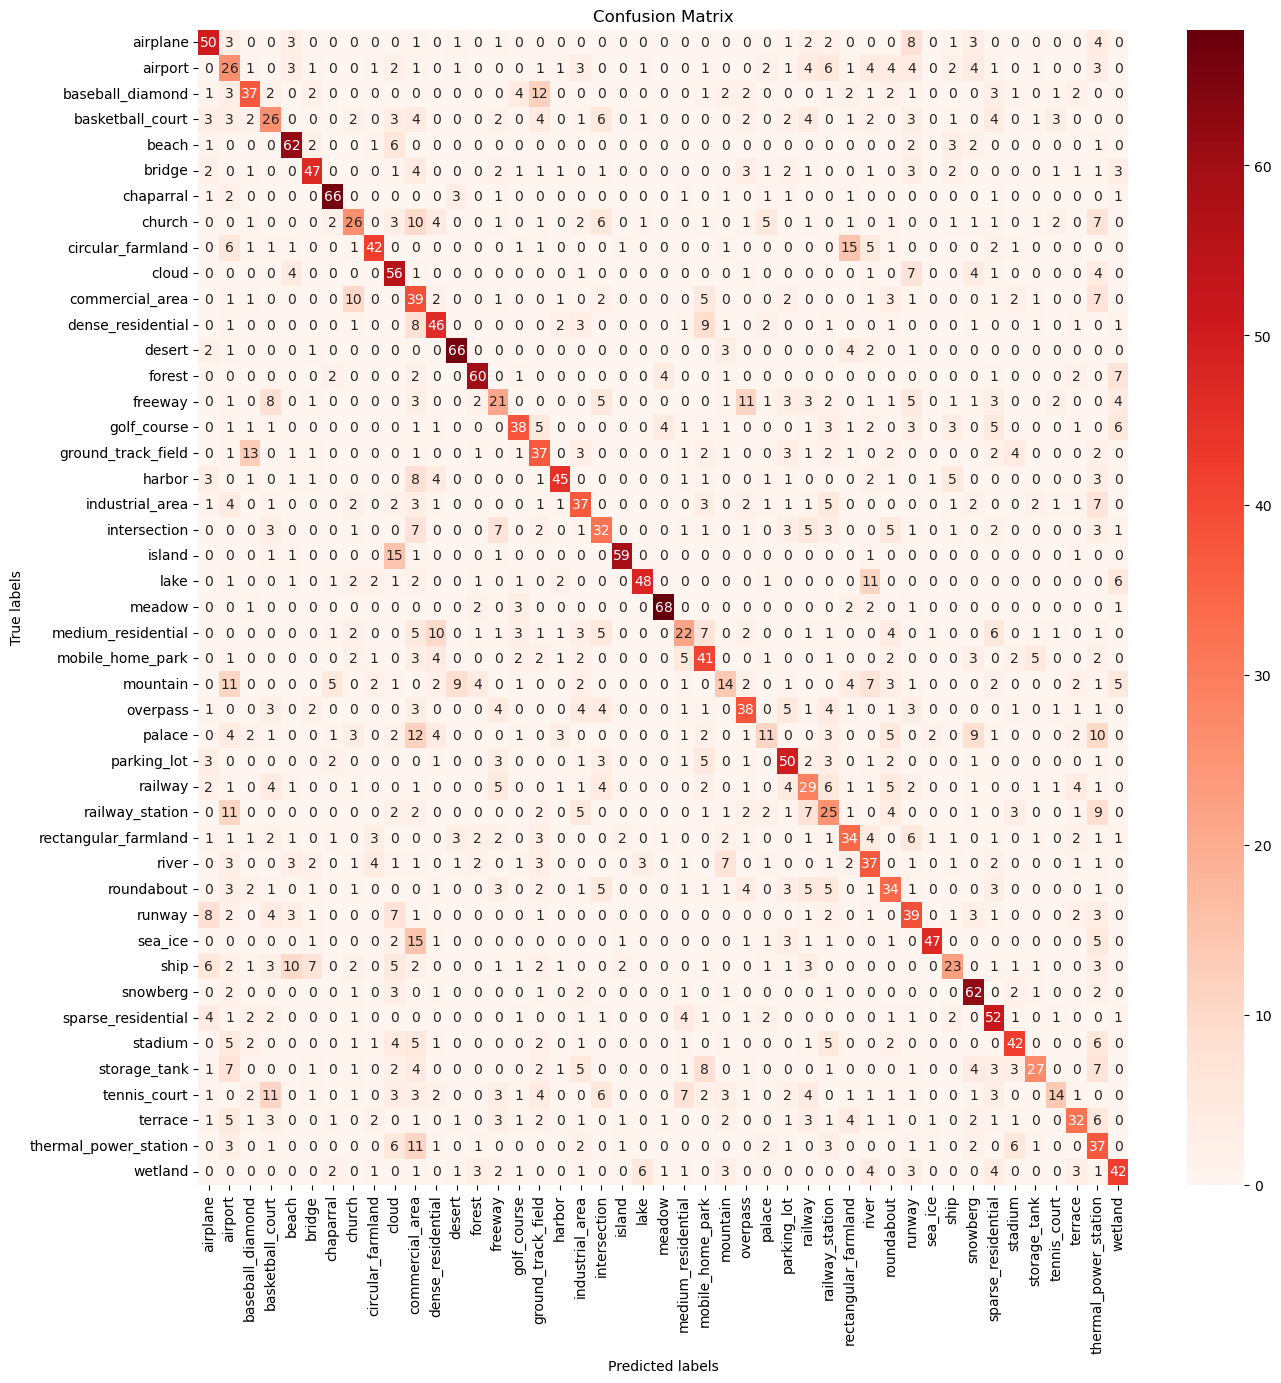

In [21]:
folders = os.listdir('NWPU_lowy400')
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print(folders)

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


In [23]:
# Calculate validation accuracy
accuracy = cm.diagonal().sum() / cm.sum()
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.4961


In [1]:
# import zipfile
# with zipfile.ZipFile('NWPU_lowy400test.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

In [ ]:
test_dataset_new = r'NWPU_lowy400end'


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale)


In [ ]:
final_test_dataset = test_datagen.flow_from_directory(batch_size=batch_size,
                                                      directory=test_dataset_new,
                                                      shuffle=False, 
                                                      target_size=(img_height, img_width),
                                                      class_mode='categorical')


In [ ]:
y_pred = []  # predicted values
y_true = []  # true values

# Predict on the final_test_dataset
for i, (image_batch, label_batch) in enumerate(final_test_dataset):
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=1))
    # Adjust this number according to the size of your new test dataset
    if i == 112:  
        break

# Concatenate the results
correct_labels = tf.concat([item for item in y_true], axis=0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# Get the confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)

# List folders from the new dataset for the labels in the confusion matrix
folders = os.listdir('NWPU_lowy400end')

# Plotting the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the Final Test Dataset')
plt.show()

# Calculate validation accuracy
accuracy = cm.diagonal().sum() / cm.sum()
print(f"Final Test Accuracy: {accuracy:.4f}")


In [7]:
model  = tf.keras.models.load_model('CNN_16_epoch')

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=8, batch_size=32)

Epoch 1/8
356/450 [======================>.......] - ETA: 4:23 - loss: 0.4639 - accuracy: 0.8689

In [ ]:
model.save('CNN_24_epoch')